<a href="https://colab.research.google.com/github/ZahibVentura/Simulaci-n-2-/blob/main/Simpy_Tarea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Simulación de Inventario en una Tienda

Una tienda necesita gestionar el inventario de sus productos. Cuando el inventario baja de un nivel crítico, se realiza un pedido para reabastecer, pero este pedido tarda algunos días en llegar. Se quiere analizar:

.La cantidad promedio de inventario restante al final de un período

.La frecuencia con la que la tienda se queda sin inventario



Datos del problema:

Nivel de reorden (20 unidades): Nivel mínimo de inventario antes de hacer un pedido.

Cantidad de pedido (50 unidades): Cantidad solicitada en cada pedido de reabastecimiento.

Tiempo de reabastecimiento (5 días): Días que tarda en llegar un pedido.

Demanda diaria promedio (10 unidades): Número promedio de productos vendidos cada día.

In [2]:
!pip install simpy

Inventario promedio final: 6.59
Tiempo promedio sin inventario: 4.32


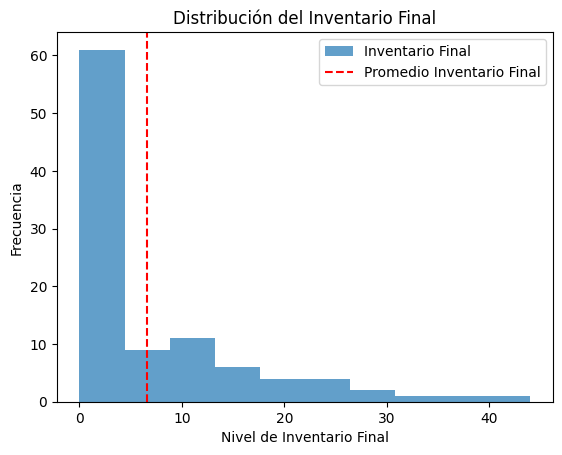

In [15]:
import simpy
import numpy as np
import matplotlib.pyplot as plt

# Parámetros de simulación
reorden_nivel = 20         # Nivel mínimo de inventario antes de reordenar
cantidad_pedido = 50       # Cantidad de productos pedidos en cada reabastecimiento
tiempo_reabastecimiento = 5 # Días que tarda en llegar el pedido
demanda_diaria = 10        # Demanda diaria promedio
dias_simulacion = 30       # Días de simulación
n_simulaciones = 100       # Número de simulaciones

# Proceso de administración de inventario en la tienda
def proceso_inventario(env, inventario, reorden_nivel, cantidad_pedido, tiempo_reabastecimiento, demanda_diaria):
    while True:
        # Genera la demanda diaria aleatoria
        demanda = np.random.poisson(demanda_diaria)

        if inventario.level > 0:
            # Si hay inventario disponible, intenta cubrir la demanda
            demanda_atendida = min(demanda, inventario.level)
            inventario.get(demanda_atendida)
        else:
            demanda_atendida = 0  # No hay inventario para cubrir la demanda

        # Revisa si es necesario hacer un pedido
        if inventario.level <= reorden_nivel and not inventario.get_queue:
            # Si está bajo el nivel de reorden y no hay pedido en camino, se hace un nuevo pedido
            env.process(reabastecer(env, inventario, cantidad_pedido, tiempo_reabastecimiento))

        # Avanza un día en la simulación
        yield env.timeout(1)

# Proceso de reabastecimiento de inventario
def reabastecer(env, inventario, cantidad_pedido, tiempo_reabastecimiento):
    # Espera el tiempo de reabastecimiento antes de agregar los productos al inventario
    yield env.timeout(tiempo_reabastecimiento)
    inventario.put(cantidad_pedido)

# Función para ejecutar la simulación y recopilar estadísticas
def simular_inventario(n_simulaciones, reorden_nivel, cantidad_pedido, tiempo_reabastecimiento, demanda_diaria, dias_simulacion):
    inventarios_finales = []
    tiempos_sin_stock = []

    for _ in range(n_simulaciones):
        env = simpy.Environment()
        # Inicializa el inventario con el nivel de reorden para empezar
        inventario = simpy.Container(env, init=reorden_nivel)
        tiempo_sin_stock = 0  # Tiempo acumulado sin inventario

        # Ejecuta el proceso principal de inventario
        env.process(proceso_inventario(env, inventario, reorden_nivel, cantidad_pedido, tiempo_reabastecimiento, demanda_diaria))

        # Monitorea el inventario cada día
        def monitorear_inventario():
            nonlocal tiempo_sin_stock
            while True:
                if inventario.level == 0:
                    tiempo_sin_stock += 1
                yield env.timeout(1)

        env.process(monitorear_inventario())
        env.run(until=dias_simulacion)

        # Guarda los resultados al final de cada simulación
        inventarios_finales.append(inventario.level)
        tiempos_sin_stock.append(tiempo_sin_stock)

    return inventarios_finales, tiempos_sin_stock

# Ejecuta la simulación y genera resultados
inventarios_finales, tiempos_sin_stock = simular_inventario(
    n_simulaciones, reorden_nivel, cantidad_pedido, tiempo_reabastecimiento, demanda_diaria, dias_simulacion)

# Resultados y gráficos
print("Inventario promedio final:", np.mean(inventarios_finales))
print("Tiempo promedio sin inventario:", np.mean(tiempos_sin_stock))

plt.hist(inventarios_finales, bins=10, alpha=0.7, label="Inventario Final")
plt.axvline(np.mean(inventarios_finales), color='r', linestyle='--', label="Promedio Inventario Final")
plt.xlabel("Nivel de Inventario Final")
plt.ylabel("Frecuencia")
plt.legend()
plt.title("Distribución del Inventario Final")
plt.show()